In [1]:
#hide
import json
from datetime import datetime, timedelta
from pytz import timezone
from time import time
from urllib.request import urlopen

import numpy as np
import numpy.polynomial.polynomial as poly

import pandas as pd

from scipy.stats import ttest_ind

import altair as alt
from altair import datum

import matplotlib.pyplot as plt

import seaborn as sns

# alt.data_transformers.enable('json');
alt.data_transformers.enable('data_server');
alt.renderers.enable('mimetype');

In [2]:
#hide
def optimize(df):
    '''
    Optimizes the data types in a pandas dataframe.
    '''
    dft = df.copy()
    # converts to datetime if possible
    dft = dft.apply(lambda col:
        pd.to_datetime(col, errors='ignore') if col.dtypes=='object' else col)
    
    # if there are less than half as many unique values as there are rows, convert to category
    for col in dft.select_dtypes(include='object'):
        if len(dft[col].unique()) / len(df[col]) < 0.5:
            dft[col] = dft[col].astype('category')
            
    # downcasts numeric columns if possible
    dft = dft.apply(lambda col: 
        pd.to_numeric(col, downcast='integer') if col.dtypes=='int64' else col)
    dft = dft.apply(lambda col: 
        pd.to_numeric(col, downcast='float') if col.dtypes=='float64' else col)
    
    return dft

In [3]:
#hide
df = optimize(pd.read_csv('../data/df.csv'))
dem_df_ac = optimize(pd.read_csv('../data/dem_df_ac.csv', 
                                 dtype={'fips':'str', 'cluster':'int'}))
la = timezone('US/Pacific')
last = df['date'].max()
df_slice = df[df['date'] == last]
df_slice.head()

,state,cluster,date,cases,deaths,county,total_pop,fips,white,black,...,delta_new_cases_7sg,delta_new_deaths_7sg,delta_new_cases_per_100k_7sg,delta_new_deaths_per_100k_7sg,delta_new_cases_15sg,delta_new_deaths_15sg,delta_new_cases_per_100k_15sg,delta_new_deaths_per_100k_15sg,days,mortality_rate
76144,Alabama,0,2020-08-10,21172,503,Autauga-Bibb-Chambers-Cherokee-Chilton-Clay-Cl...,1102710,01001-01007-01017-01019-01021-01027-01029-0103...,803698,223784,...,-52.821430,3.250000e+00,-4.790147,2.947284e-01,-37.216667,2.233333,-3.375019,0.202531,202,0.023758
76145,Alabama,7,2020-08-10,14313,240,Baldwin-Mobile,636444,01003-01097,419294,167703,...,206.642853,-1.285714e+00,32.468349,-2.020153e-01,86.816666,-0.783333,13.640897,-0.123080,202,0.016768
76146,Alabama,3,2020-08-10,13074,285,Barbour-Bullock-Butler-Choctaw-Clarke-Conecuh-...,419390,01005-01011-01013-01023-01025-01035-01041-0104...,186960,208094,...,47.571430,1.071429e-01,11.343005,2.554731e-02,29.991667,-0.041667,7.151259,-0.009935,202,0.021799
76147,Alabama,1,2020-08-10,23818,260,Blount-Calhoun-Colbert-DeKalb-Etowah-Franklin-...,1198752,01009-01015-01033-01049-01055-01059-01071-0107...,945774,130787,...,-43.035713,5.000000e-01,-3.590043,4.171005e-02,-40.983334,0.808333,-3.418833,0.067431,202,0.010916
76148,Alabama,4,2020-08-10,4582,72,Coffee-Covington-Dale-Geneva-Henry-Houston,287921,01031-01039-01045-01061-01067-01069,204415,59030,...,-10.642858,-1.978261e-16,-3.696450,2.089088e-15,-9.983334,-0.058333,-3.467386,-0.020260,202,0.015714


In [4]:
df.columns

Index(['state', 'cluster', 'date', 'cases', 'deaths', 'county', 'total_pop',
       'fips', 'white', 'black', 'asian', 'hispanic', 'area_land', 'lon',
       'lat', 'votes_gop', 'votes_dem', 'total_votes', 'median_income',
       'pop25', 'no_hs', 'some_hs', 'hs', 'some_college', 'associates',
       'bachelors', 'graduate', 'never', 'rarely', 'sometimes', 'frequently',
       'always', 'pop_density', 'per_white', 'per_black', 'per_asian',
       'per_hispanic', 'per_total_votes', 'per_votes_gop', 'per_votes_dem',
       'education', 'mask', 'per_gop', 'cases_per_100k', 'deaths_per_100k',
       'new_cases', 'new_deaths', 'new_cases_per_100k', 'new_deaths_per_100k',
       'new_cases_7sg', 'new_deaths_7sg', 'new_cases_per_100k_7sg',
       'new_deaths_per_100k_7sg', 'new_cases_15sg', 'new_deaths_15sg',
       'new_cases_per_100k_15sg', 'new_deaths_per_100k_15sg',
       'delta_new_cases', 'delta_new_deaths', 'delta_new_cases_per_100k',
       'delta_new_deaths_per_100k', 'delta_new_cas

In [5]:
#hide
#https://colorbrewer2.org/

color_dict = dict(
    # blue-red
    per_gop=dict(
        range=['#2166ac', '#F7F7F7', '#b2182b'],
        mid=0.5
    ),
    # pink-green
    mask=dict(
        range=['#c51b7d', '#F7F7F7', '#4d9221'],
        mid=dem_df_ac['mask'].median()
    ),
    # purple-orange
    median_income=dict(
        range=['#542788', '#F7F7F7', '#b35806'],
        mid=61937
    ),
    # green-purple
    education=dict(
        range=['#1b7837', '#F7F7F7', '#762a83'],
        mid=dem_df_ac['education'].median()
    )
)

# Funnel Charts

In [28]:
#collapse-hide
def make_funnel_chart(df, x_col, c_col, c_range=None, c_mid=None):

    x_col_2 = x_col + '_per_100k_15sg'
    cols = ['date', 'state', 'county', 'total_pop'] + [x_col, x_col_2, c_col]

    df = df[df['date'] >= '2020-03-01'][cols]
    
    base = alt.Chart(df).properties(
        title=x_col + ' vs. ' + c_col,
        width=480,
        height=720
    )
    
    c_datum = 'datum.' + c_col
    x_datum = 'datum.' + x_col
    
    pop_left = df[df[c_col]<=c_mid]['total_pop'].sum()
    pop_right = df[df[c_col]>c_mid]['total_pop'].sum()

    # left of iceberg: c_col <= cutoff_val
    left = base.mark_area().transform_filter(
        (eval(c_datum) <= c_mid)
    ).transform_calculate(
        per_x=f'{x_datum}/{pop_left}*-100000'
    ).encode(
        alt.X('per_x:Q'),
        alt.Y('date:T', title='Date'),
        order=alt.Order(c_col, sort='descending')
    )
    
    # right of iceberg: c_col > cutoff_val
    right = base.mark_area().transform_filter(
        (eval(c_datum) > c_mid)
    ).transform_joinaggregate(
        pop_right='sum(total_pop)',
    ).transform_calculate(
        per_x=f'{x_datum}/{pop_right}*100000'
    ).encode(
        alt.X(
            'per_x:Q', 
            title='Per 100k of Represented Population'
        ),
        alt.Y('date:T', title='Date'),
        order=alt.Order(c_col, sort='ascending')
    )   
    
    # just a line at zero to make it easier to see
    zero = alt.Chart(pd.DataFrame({'x': [0]})).mark_rule(
        color='black',
        size=0.5
    ).encode(x='x')

    # find dates where {new cases} is statistically different between halves
    dates = [[], []]
    for date in df['date'].unique():
        df_ = df[df['date'] == date]
        df0_ = df_[df_[c_col]<=c_mid][x_col_2].values
        df1_ = df_[df_[c_col]>c_mid][x_col_2].values
        t, p = ttest_ind(df0_, df1_)
        # two-tailed t-test; p/2 < alpha
        if p/2 < 0.05:
            # if df0_.mean() > df1_.mean()
            if t > 0: 
                dates[0].append(date)
            else:
                dates[1].append(date)


    # https://stackoverflow.com/a/6934267
    def get_ranges(d):
        last_date = d[-1]
        while d:
            end = 1
            try:
                while d[end] - d[end - 1] == np.timedelta64(1, 'D'):
                    end += 1
            except IndexError:
                pass
            if d[end-1] == last_date:
                end_date = d[end-1]
            else:
                end_date = d[end-1] + np.timedelta64(1, 'D')
            yield {'start': d[0],
                   'end': end_date}
            d = d[end:]

    rects = []
    for i, d in enumerate(dates):
        if len(d) > 0:
            ranges = alt.pd.DataFrame(get_ranges(d))
            rects.append(
                alt.Chart(ranges).mark_rect(
                    color=c_range[-1*i], 
                    opacity=0.1
                ).encode(
                    y='start:T',
                    y2='end:T'
                )
            )
            
    ranked_text = alt.Chart(df).mark_text().encode(
        y=alt.Y('row_number:O', axis=None)
    ).transform_window(
        row_number='row_number()'
    )
    
    funnel = alt.layer(left, right).encode(
        color=alt.Color(
            c_col + ':Q',
            scale=alt.Scale(
                range=c_range,
                domain=[np.percentile(dem_df_ac[c_col], 1),
                        c_mid,
                        np.percentile(dem_df_ac[c_col], 99)],
                interpolate={
                    'type':'rgb', 
                    'gamma':0.75
                }
            ),
        ),
        tooltip=[
            'state:N', 'county:N', 'date:T',
            alt.Tooltip(
                x_col + ':Q',
                format='.2f',
            ),
            alt.Tooltip(
                c_col + ':Q',
                format='.2f',
            )
        ]
    )

    layer = alt.layer(*rects, funnel, zero)
    
    return layer

In [21]:
#collapse-hide
def make_funnel_chart_raw(df, x_col, c_col, c_range=None, c_mid=None):

    x_col_2 = x_col + '_per_100k_15sg'
    cols = ['date', 'state', 'county', 'total_pop'] + [x_col, x_col_2, c_col]

    df = df[df['date'] >= '2020-03-01'][cols]
    
    base = alt.Chart(df).properties(
        title=x_col + ' vs. ' + c_col,
        width=480,
        height=720
    )
    
    c_datum = 'datum.' + c_col
    x_datum = 'datum.' + x_col

    # left of iceberg: c_col <= cutoff_val
    left = base.mark_area().transform_filter(
        (eval(c_datum) <= c_mid)
#     ).transform_joinaggregate(
#         pop_left='sum(total_pop)',
    ).transform_calculate(
        alt_x=x_datum + ' * -1'
    ).encode(
        alt.X('alt_x:Q'),
        alt.Y('date:T', title='Date'),
        order=alt.Order(c_col, sort='descending')
    )
    
    # right of iceberg: c_col > cutoff_val
    right = base.mark_area().transform_filter(
        (eval(c_datum) > c_mid)
#     ).transform_joinaggregate(
#         pop_right='sum(total_pop)',
#     ).transform_calculate(
#         per_x=x_datum + ' / datum.pop_right * 100000'
    ).encode(
        alt.X(
            f'{x_col}:Q', 
            title='New Cases'
        ),
        alt.Y('date:T', title='Date'),
        order=alt.Order(c_col, sort='ascending')
    )   
    
    # just a line at zero to make it easier to see
    zero = alt.Chart(pd.DataFrame({'x': [0]})).mark_rule(
        color='black',
        size=0.5
    ).encode(x='x')

    # find dates where {new cases} is statistically different between halves
    dates = [[], []]
    for date in df['date'].unique():
        df_ = df[df['date'] == date]
        df0_ = df_[df_[c_col]<=c_mid][x_col_2].values
        df1_ = df_[df_[c_col]>c_mid][x_col_2].values
        t, p = ttest_ind(df0_, df1_)
        # two-tailed t-test; p/2 < alpha
        if p/2 < 0.05:
            # if df0_.mean() > df1_.mean()
            if t > 0: 
                dates[0].append(date)
            else:
                dates[1].append(date)


    # https://stackoverflow.com/a/6934267
    def get_ranges(d):
        last_date = d[-1]
        while d:
            end = 1
            try:
                while d[end] - d[end - 1] == np.timedelta64(1, 'D'):
                    end += 1
            except IndexError:
                pass
            if d[end-1] == last_date:
                end_date = d[end-1]
            else:
                end_date = d[end-1] + np.timedelta64(1, 'D')
            yield {'start': d[0],
                   'end': end_date}
            d = d[end:]

    rects = []
    for i, d in enumerate(dates):
        if len(d) > 0:
            ranges = alt.pd.DataFrame(get_ranges(d))
            rects.append(
                alt.Chart(ranges).mark_rect(
                    color=c_range[-1*i], 
                    opacity=0.1
                ).encode(
                    y='start:T',
                    y2='end:T'
                )
            )
            
    ranked_text = alt.Chart(df).mark_text().encode(
        y=alt.Y('row_number:O', axis=None)
    ).transform_window(
        row_number='row_number()'
    )
    
    funnel = alt.layer(left, right).encode(
        color=alt.Color(
            c_col + ':Q',
            scale=alt.Scale(
                range=c_range,
                domain=[np.percentile(dem_df_ac[c_col], 1),
                        c_mid,
                        np.percentile(dem_df_ac[c_col], 99)],
                interpolate={
                    'type':'rgb', 
                    'gamma':0.75
                }
            ),
        ),
        tooltip=[
            'state:N', 'county:N', 'date:T',
            alt.Tooltip(
                x_col + ':Q',
                format='.2f',
            ),
            alt.Tooltip(
                c_col + ':Q',
                format='.2f',
            )
        ]
    )

    layer = alt.layer(*rects, funnel, zero)
    
    return layer

## New Cases vs. Percent GOP

In [25]:
dem_df_ac[dem_df_ac['per_gop'] <= 0.5]['total_pop'].sum()

177999382

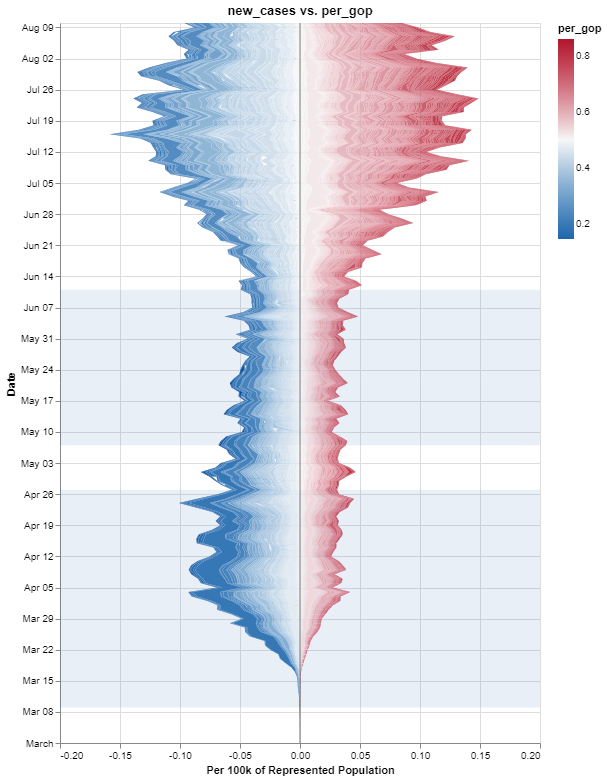

In [29]:
x = 'per_gop'
funnel_gop = make_funnel_chart(df, 'new_cases', x, color_dict[x]['range'], color_dict[x]['mid'])
# ice_gop.save('docs/ice_gop.html')
funnel_gop

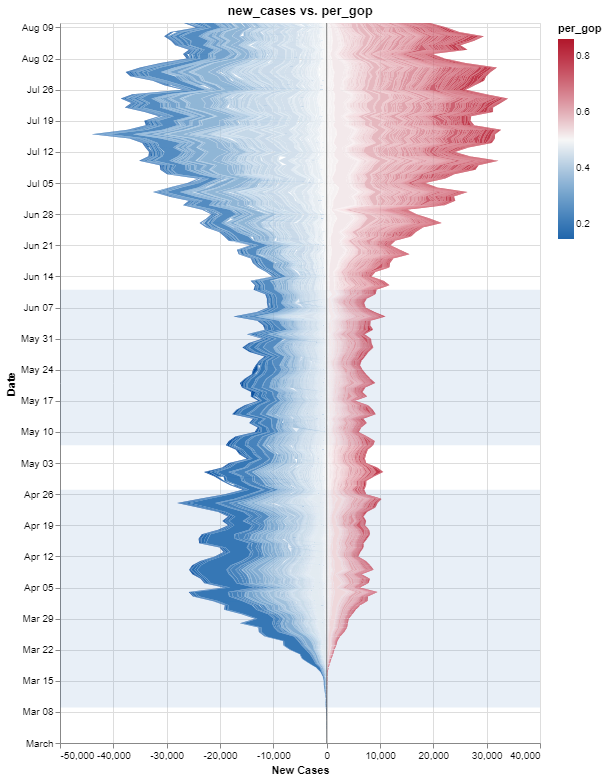

In [23]:
x = 'per_gop'
funnel_gop = make_funnel_chart_raw(df, 'new_cases', x, color_dict[x]['range'], color_dict[x]['mid'])
# ice_gop.save('docs/ice_gop.html')
funnel_gop

Democratic counties still comprise most daily cases compared to their Republican counterparts. However, when splitting the country into "Democratic" and "Republican" halves, we see that Republican-leaning counties currently account for more than half of the new daily cases.

## Comparing New Cases vs. Educational Attainment

Counties with lower educational attainment coefficient have a disproportionate share of new cases:

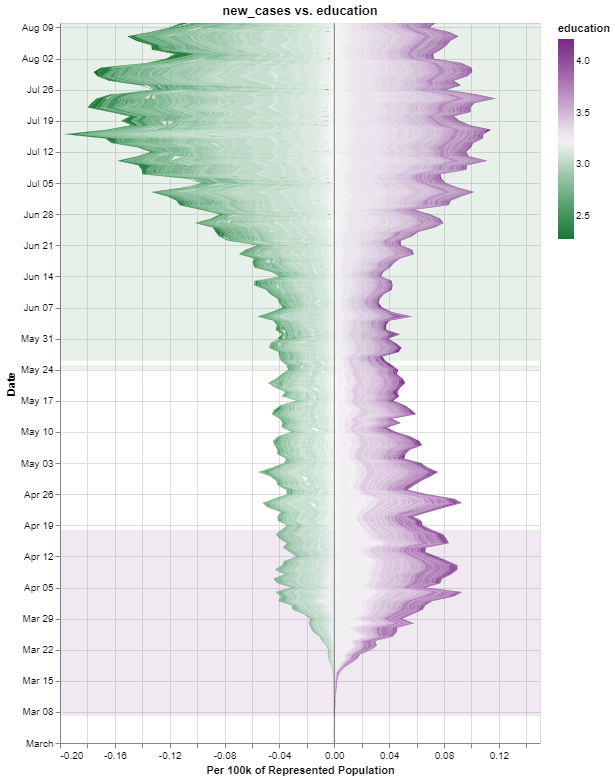

In [12]:
x = 'education'
funnel_edu = make_funnel_chart(df, 'new_cases', x, color_dict[x]['range'], color_dict[x]['mid'])
funnel_edu

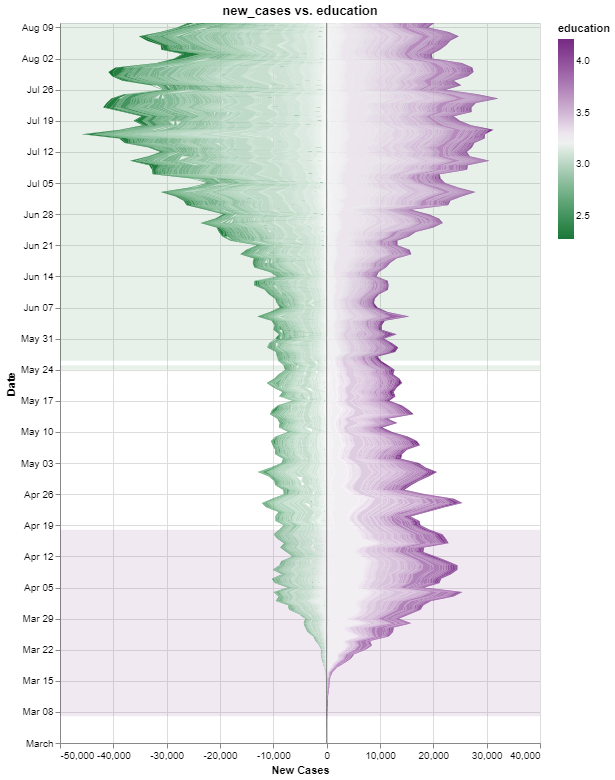

In [31]:
x = 'education'
make_funnel_chart_raw(df, 'new_cases', x, color_dict[x]['range'], color_dict[x]['mid'])

## Comparing New Cases vs. Median Income

Strangely enough, while there didn't seem to be a large correlation between new cases and median income (for the most recent 15-day window), we can see from this iceberg plot that low-income counties are currently disproportionately affected by COVID-19.

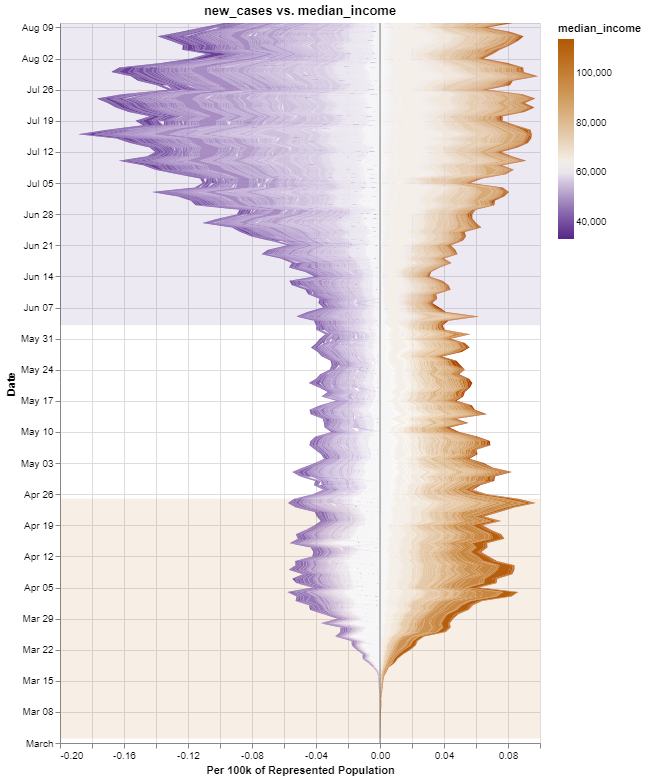

In [13]:
#hide_input
x = 'median_income'
funnel_inc = make_funnel_chart(df, 'new_cases', x, color_dict[x]['range'], color_dict[x]['mid'])
funnel_inc

## Comparing New Cases vs. Mask Discipline

While dense counties were hit the hardest in the beginning, they seem to be doing slightly better

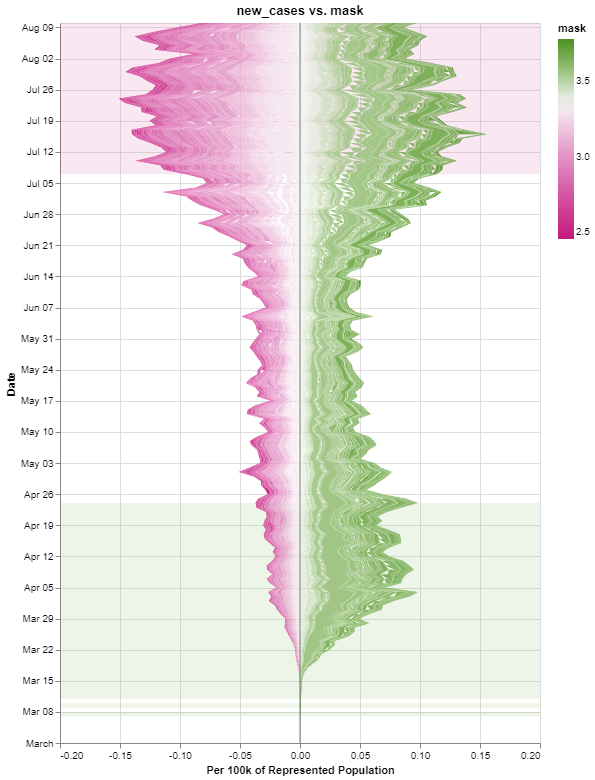

In [14]:
#hide_input
x = 'mask'
funnel_mask = make_funnel_chart(df, 'new_cases', x, color_dict[x]['range'], color_dict[x]['mid'])
funnel_mask

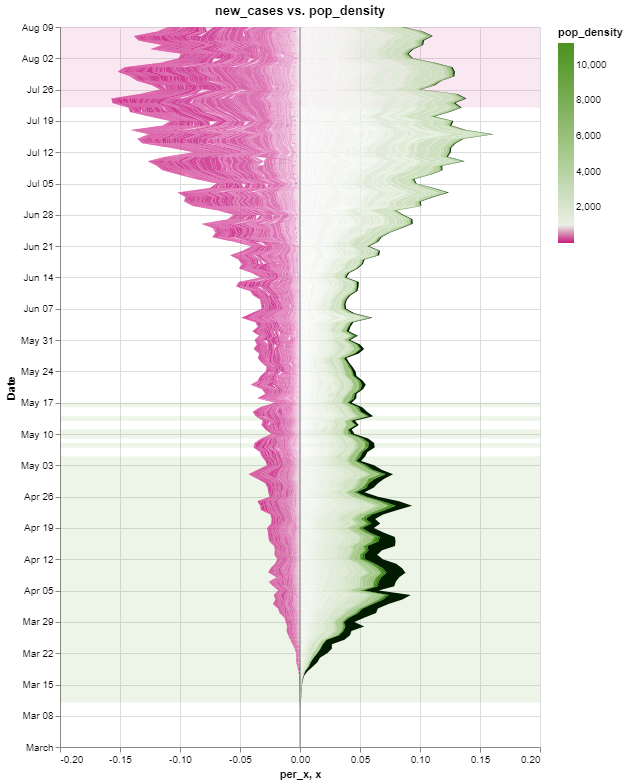

In [16]:
make_funnel_chart(df, 'new_cases', 'pop_density', ['#c51b7d', '#F7F7F7', '#4d9221'], dem_df_ac['pop_density'].median())